In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
print(keras.__version__)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from math import nan
from keras.callbacks import ModelCheckpoint, EarlyStopping

!pip install git+https://www.github.com/keras-team/keras-contrib.git
from keras_contrib.layers import CRF

# from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))

# # Any results you write to the current directory are saved as output.

Using TensorFlow backend.


2.2.4
  Cloning https://www.github.com/keras-team/keras-contrib.git to c:\users\mfthr\appdata\local\temp\pip-req-build-yeck46us
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git 'C:\Users\mfthr\AppData\Local\Temp\pip-req-build-yeck46us'


# Data Prep


## Importing the dataset for named entity recognition model

In [2]:
dframe = pd.read_csv("data_cleaned_v1.csv")

## Penjelasan Tag yang dipakai

- B-SEAWEED: Digunakan untuk menandai kata pertama dari entitas yang berkaitan dengan "seaweed" atau rumput laut. Misalnya, dalam "Gracilaria verrucosa", kata "Gracilaria" akan diberi label B-SEAWEED.

- B-LOC: Digunakan untuk menandai kata pertama dari entitas yang berkaitan dengan lokasi. Misalnya, dalam "Pulau Bali", kata "Pulau" akan diberi label B-LOC.

Jika entitas terdiri dari lebih dari satu kata, kata-kata berikutnya akan diberi label I-SEAWEED dan I-LOC untuk menunjukkan bahwa mereka adalah bagian dari entitas yang sama. Misalnya, "Gracilaria verrucosa dari Pulau Bali" akan diberi label seperti ini:

- Gracilaria: B-SEAWEED
- verrucosa: I-SEAWEED
- dari: O (bukan entitas)
- Pulau: B-LOC
- Bali: I-LOC

In [3]:
dframe.head()

,word,label,sentence_idx
0,Abstrak,O,0
1,Kegiatan,O,0
2,pengabdian,O,0
3,kepada,O,0
4,masyarakat,O,0


## Data preprocessing

In [4]:
dframe.columns

Index(['word', 'label', 'sentence_idx'], dtype='object')

## Menjadikan word, label, dan sentence_idx sebagai input

In [5]:
dataset = dframe

# # Update dataset dengan data yang diundursampling
# dataset = data_balanced

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143437 entries, 0 to 143436
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   word          143437 non-null  object
 1   label         143437 non-null  object
 2   sentence_idx  143437 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 3.3+ MB


In [7]:
dataset.head()

,word,label,sentence_idx
0,Abstrak,O,0
1,Kegiatan,O,0
2,pengabdian,O,0
3,kepada,O,0
4,masyarakat,O,0


In [8]:
dataset.head()

,word,label,sentence_idx
0,Abstrak,O,0
1,Kegiatan,O,0
2,pengabdian,O,0
3,kepada,O,0
4,masyarakat,O,0


## Create list of list of tuples to differentiate each sentence from each other

In [9]:
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["word"].values.tolist(),
                                                        s["label"].values.tolist())]
        self.grouped = self.dataset.groupby("sentence_idx").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [10]:
getter = SentenceGetter(dataset)

In [11]:
sentences = getter.sentences

In [12]:
print(sentences[29])

[('Diversifikasi', 'O'), ('produk', 'O'), ('jenis', 'O'), ('Eucheuma', 'B-RUMPUT LAUT'), ('cottoni', 'I-RUMPUT LAUT'), ('menjadi', 'O'), ('minuman', 'O'), ('khas', 'O'), ('daerah', 'O'), ('berupa', 'O'), ('dawet', 'O'), ('bertujuan', 'O'), ('menghasilkan', 'O'), ('dawet', 'O'), ('Eucheuma', 'B-RUMPUT LAUT'), ('cottoni', 'I-RUMPUT LAUT'), ('serta', 'O'), ('mengetahui', 'O'), ('perbandingan', 'O'), ('jumlah', 'O'), ('adonan', 'O'), ('dawet', 'O'), ('menghasilkan', 'O'), ('tekstur', 'O'), ('aroma', 'O'), ('rasa', 'O'), ('dawet', 'O'), ('disukai', 'O'), ('cara', 'O'), ('pembuatan', 'O'), ('bubur', 'O'), ('adonan', 'O'), ('dawet', 'O'), ('Perlakuan', 'O'), ('mengetahui', 'O'), ('perbandingan', 'O'), ('adonan', 'O'), ('agar', 'O'), ('mendapatkan', 'O'), ('dawet', 'O'), ('paling', 'O'), ('disukai', 'O'), ('oleh', 'O'), ('panelis', 'O'), ('Perlakuan', 'O'), ('perbandingan', 'O'), ('antara', 'O'), ('bubur', 'O'), ('adonan', 'O'), ('dawet', 'O'), ('antara', 'O'), ('lain', 'O'), ('P1', 'O'), ('0'

In [13]:
maxlen = max([len(s) for s in sentences])
print ('Maximum sequence length:', maxlen)

Maximum sequence length: 249


In [16]:
words = list(set(dataset["word"].values))
words.append("ENDPAD")

In [17]:
n_words = len(words); n_words

16513

## Fix the tags

In [18]:
tags = []
for tag in set(dataset["label"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
print(tags)

['B-LOKASI', 'I-LOKASI', 'B-RUMPUT LAUT', 'O', 'I-RUMPUT LAUT']


In [19]:
n_tags = len(tags); n_tags

5

**Converting words to numbers and numbers to words**

In [20]:
from future.utils import iteritems
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

In [21]:
word2idx['Desa']

7865

In [23]:
tag2idx

{'B-LOKASI': 0, 'I-LOKASI': 1, 'B-RUMPUT LAUT': 2, 'O': 3, 'I-RUMPUT LAUT': 4}

In [24]:
idx2tag[0]

'B-LOKASI'

In [25]:
idx2tag

{0: 'B-LOKASI', 1: 'I-LOKASI', 2: 'B-RUMPUT LAUT', 3: 'O', 4: 'I-RUMPUT LAUT'}

In [26]:
sentences[66]

[('Persediaan', 'O'),
 ('Bahan', 'O'),
 ('Bakar', 'O'),
 ('Minyak', 'O'),
 ('BBM', 'O'),
 ('semakin', 'O'),
 ('menipis', 'O'),
 ('suatu', 'O'),
 ('saat', 'O'),
 ('habis', 'O'),
 ('sama', 'O'),
 ('sekali', 'O'),
 ('Pemakaian', 'O'),
 ('energi', 'O'),
 ('BBM', 'O'),
 ('juga', 'O'),
 ('menghasilkan', 'O'),
 ('polusi', 'O'),
 ('berakibat', 'O'),
 ('pemanasan', 'O'),
 ('global', 'O'),
 ('Diperlukan', 'O'),
 ('upaya', 'O'),
 ('pengadaan', 'O'),
 ('energi', 'O'),
 ('alternatif', 'O'),
 ('mengurangi', 'O'),
 ('ketergantungan', 'O'),
 ('bahan', 'O'),
 ('bakar', 'O'),
 ('bersumber', 'O'),
 ('fosil', 'O'),
 ('sehingga', 'O'),
 ('perlu', 'O'),
 ('dikembangkan', 'O'),
 ('pemanfaatan', 'O'),
 ('energi', 'O'),
 ('baru', 'O'),
 ('terbarukan', 'O'),
 ('seperti', 'O'),
 ('biofuel', 'O'),
 ('Akan', 'O'),
 ('tetapi', 'O'),
 ('proses', 'O'),
 ('beberapa', 'O'),
 ('tanaman', 'O'),
 ('sumber', 'O'),
 ('biofuel', 'O'),
 ('memerlukan', 'O'),
 ('lahan', 'O'),
 ('cukup', 'O'),
 ('luas', 'O'),
 ('lahan', 'O'),
 (

In [27]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]

In [28]:
np.array(X).shape

c:\Users\mfthr\anaconda3\envs\BiLSTMCRF\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


(1078,)

In [29]:
X = pad_sequences(maxlen=maxlen, sequences=X, padding="post",value=n_words - 1)

In [30]:
y_idx = [[tag2idx[w[1]] for w in s] for s in sentences]
print(sentences[11])
print(y_idx[11])

[('bertujuan', 'O'), ('mengetahui', 'O'), ('menganalisa', 'O'), ('bagaimana', 'O'), ('gambaran', 'O'), ('UKM', 'O'), ('pantai', 'B-LOKASI'), ('amal', 'I-LOKASI'), ('dinilai', 'O'), ('usaha', 'O'), ('ukm', 'O'), ('milik', 'O'), ('Pak', 'O'), ('jaka', 'O'), ('digolongkan', 'O'), ('masih', 'O'), ('kurang', 'O'), ('layak', 'O'), ('dijalankan', 'O'), ('dikarenakan', 'O'), ('aspek-aspek', 'O'), ('dinilai', 'O'), ('hanya', 'O'), ('2', 'O'), ('aspek', 'O'), ('cukup', 'O'), ('atau', 'O'), ('melebihi', 'O'), ('setengah', 'O'), ('skor', 'O'), ('diberikan', 'O'), ('Kedua', 'O'), ('aspek', 'O'), ('tesebut', 'O'), ('meliputi', 'O'), ('Aspek', 'O'), ('Produksi', 'O'), ('15', 'O'), ('skor', 'O'), ('28', 'O'), ('kedua', 'O'), ('Aspek', 'O'), ('Lingkungan', 'O'), ('12', 'O'), ('24', 'O')]
[3, 3, 3, 3, 3, 3, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [31]:
y = pad_sequences(maxlen=249, sequences=y_idx, padding="post", value=tag2idx["O"])
print(y_idx[10])

[3, 3, 3, 2, 4, 3, 3, 3, 3, 3, 0, 1, 1, 0, 1, 1, 3, 3, 3, 3, 3, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [32]:
print(dataset["label"].value_counts())

O                132743
I-LOKASI           3288
B-LOKASI           3007
B-RUMPUT LAUT      2576
I-RUMPUT LAUT      1823
Name: label, dtype: int64


In [33]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [35]:
X_test[90]

array([11572,  5650, 12841,  4928,  5406, 13408,  2312,  4261, 12103,
       10877,  5558,  5406, 13199, 13237,  8773,  8053, 13237,  2337,
        7028,  7342, 12088,  6754,  9191,  7493, 14635, 13225, 10070,
       12088, 16179, 13127, 11106, 12673,  8188,  9940, 15278, 15802,
        8959, 13207, 12077, 13408,  8294,  8773,   808, 16294, 12077,
       13408,  8294,  8773, 13284, 12711, 12077, 13408,  8294,  8773,
        7076,  1216,  6330, 12882, 12368,  4261, 12103, 10877,  4997,
       12183, 15767,  5406, 11901,  2495,   694,  7901,  5162,  7187,
        9626,  1097, 12146, 12690,  4928,  8294,  8773,  7840,  6346,
       14647,  6619,  3375, 13347, 10105, 12249,  4997, 12183, 15767,
        6647,  4304,  7840,  6346, 10877,  5406, 13408,  2312, 14965,
       12249, 13207, 16294, 12711, 13897, 11094, 10776,  5149,  6236,
       10877, 13207, 16294, 12711, 10851,  4908, 10909,  6236, 10105,
        4997, 13207, 12711, 16294,  5208, 15005,  5399,  6236, 10105,
       12183, 13207,

In [36]:
y_test[1]

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

# Build Model

## Import Keras

In [37]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
import keras as k

## Keras version

In [38]:
print(k.__version__)

2.2.4


## Model
 **Pay attention to the word embedding size

In [39]:
max_sequence_length = 249
word_embedding_size = 100
lstm_units = 64
dropout_rate = 0.3

input = Input(shape=(max_sequence_length,))
model = Embedding(
    input_dim=n_words, output_dim=word_embedding_size, input_length=max_sequence_length
)(input)
model = Bidirectional(
    LSTM(
        units=lstm_units,
        return_sequences=True,
        dropout=dropout_rate,
        recurrent_dropout=dropout_rate,
        kernel_initializer=k.initializers.he_normal(),
    )
)(model)
model = LSTM(
    units=lstm_units * 2,
    return_sequences=True,
    dropout=dropout_rate,
    recurrent_dropout=dropout_rate,
    kernel_initializer=k.initializers.he_normal(),
)(model)
model = TimeDistributed(Dense(n_tags, activation="relu"))(model)

crf = CRF(n_tags)
out = crf(model)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [40]:
model = Model(input, out)

In [41]:
adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)
#model.compile(optimizer=adam, loss="categorical_crossentropy", metrics=["accuracy"])
model.compile(optimizer=adam, loss=crf.loss_function, metrics=[crf.accuracy, 'accuracy'])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


c:\Users\mfthr\anaconda3\envs\BiLSTMCRF\lib\site-packages\keras_contrib\layers\crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
c:\Users\mfthr\anaconda3\envs\BiLSTMCRF\lib\site-packages\keras_contrib\layers\crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


In [42]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 249)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 249, 100)          1651300   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 249, 128)          84480     
_________________________________________________________________
lstm_2 (LSTM)                (None, 249, 128)          131584    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 249, 5)            645       
_________________________________________________________________
crf_1 (CRF)                  (None, 249, 5)            65        
Total params: 1,868,074
Trainable params: 1,868,074
Non-trainable params: 0
_________________________________________________________________


## Save the model after each epoch if validation is better

In [43]:
# Saving the best only
filepath = "output 2/ner-bi-lstm-td-model-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(
    filepath, monitor="val_acc", verbose=1, save_best_only=True, mode="max"
)

# Early Stopping
early_stopping = EarlyStopping(
    monitor="val_acc",  # Bisa juga menggunakan 'val_acc'
    patience=5,  # Berhenti jika tidak ada peningkatan selama 5 epoch
    restore_best_weights=True,  # Mengembalikan bobot terbaik ketika berhenti
    verbose=1,
)

# # Gabungkan kedua callback
# callbacks_list = [checkpoint, early_stopping]

callbacks_list = [checkpoint]

## Fit

In [44]:
print(X_train.shape)

(862, 249)


In [45]:
history = model.fit(X_train, np.array(y_train), batch_size=16, epochs=20, validation_split=0.2, verbose=1, callbacks=callbacks_list)




Train on 689 samples, validate on 173 samples
Epoch 1/20





689/689 [==============================] - 23s 33ms/step - loss: 0.7915 - crf_viterbi_accuracy: 0.6060 - acc: 0.0109 - val_loss: 0.2457 - val_crf_viterbi_accuracy: 0.9573 - val_acc: 0.9573

Epoch 00001: val_acc improved from -inf to 0.95726, saving model to output 2/ner-bi-lstm-td-model-01-0.96.hdf5
Epoch 2/20
689/689 [==============================] - 21s 30ms/step - loss: 0.2153 - crf_viterbi_accuracy: 0.9609 - acc: 0.0109 - val_loss: 0.2289 - val_crf_viterbi_accuracy: 0.9573 - val_acc: 0.9573

Epoch 00002: val_acc did not improve from 0.95726
Epoch 3/20
689/689 [==============================] - 22s 32ms/step - loss: 0.2038 - crf_viterbi_accuracy: 0.9610 - acc: 0.0109 - val_loss: 0.2082 - val_crf_viterbi_accuracy: 0.9573 - val_acc: 0.9573

Epoch 00003: val_acc did not improve from 0.95726
Epoch 4/20
689/689 [==============================] - 22s 32ms/step - loss: 0.1896 - crf_viterbi_accuracy: 0.9611 - acc: 0.0109 - va

# Accuracy

## Single prediction and verbose results

In [46]:
i = 55
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
gt = np.argmax(y_test[i], axis=-1)
print(gt)
print("{:14}: ({:10}): {}".format("Word", "True", "Pred"))
for idx, (w,pred) in enumerate(zip(X_test[i],p[0])):
    #
    print("{:14}: ({:10}): {}".format(words[w],idx2tag[gt[idx]],tags[pred]))

[3 3 3 3 3 3 3 3 3 3 2 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 2 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 4 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 2 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
Word          : (True      ): Pred
ABSTRAK       : (O         ): O
Telah         : (O         ): O
tentang       : (O         ): O
efek          : (O         ): O
kelapa        : (O         ): O
penarikan     : (O         ): O
agar          : (O         ): O
proses        : (O         ): O
pengolahan    : (O         ): O
pascapanen    : (O         ): O
Gracilaria    : (B-RUMPUT LAUT): B-RUMPUT LAUT
gigas         : (I-RUMPUT LAUT): I-RUMPUT LAUT
Harv.         : (O         ): O
Tujuan       

## Random Predict

In [47]:
def preprocess_input_text(input_text, word2idx, maxlen):
    # Split the input text into words (assumes space-separated words)
    words = input_text.split()

    # Convert words to their corresponding indices
    X_input = [word2idx.get(w, word2idx["ENDPAD"]) for w in words]  # Use ENDPAD for unknown words

    # Pad the sequence to the required maxlen
    X_input_padded = pad_sequences([X_input], maxlen=maxlen, padding="post", value=word2idx["ENDPAD"])

    return X_input_padded, words


In [48]:
def predict_entities(input_text, model, word2idx, idx2tag, maxlen):
    # Preprocess the input text
    X_input_padded, words = preprocess_input_text(input_text, word2idx, maxlen)
    
    # Predict using the model
    pred = model.predict(X_input_padded)
    
    # Get the predicted tags (indices) and convert them to actual tags
    pred_tags = [idx2tag[np.argmax(tag)] for tag in pred[0]]
    
    return list(zip(words, pred_tags))


In [49]:
# Input text
input_text = "Eucheuma cottoni di Kabupaten Brebes Provinsi Jawa Tengah."


# Predict the entities in the input text
predicted_entities = predict_entities(input_text, model, word2idx, idx2tag, maxlen)

# Print the results
for word, tag in predicted_entities:
    print(f"{word}: {tag}")


Eucheuma: B-RUMPUT LAUT
cottoni: I-RUMPUT LAUT
di: O
Kabupaten: B-LOKASI
Brebes: I-LOKASI
Provinsi: B-LOKASI
Jawa: I-LOKASI
Tengah.: O


## Predict everything at once

In [50]:
p = model.predict(np.array(X_test))  

In [51]:
p.shape

(216, 249, 5)

## Sklearn Classification Report

In [52]:
from sklearn.metrics import classification_report

In [53]:
np.argmax(p, axis=2)[0]

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 2, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3], dtype=int64)

In [54]:
print(classification_report(np.argmax(y_test, 2).ravel(), np.argmax(p, axis=2).ravel(),labels=list(idx2tag.keys()), target_names=list(idx2tag.values())))

               precision    recall  f1-score   support

     B-LOKASI       0.85      0.81      0.83       575
     I-LOKASI       0.88      0.84      0.86       662
B-RUMPUT LAUT       0.95      0.88      0.91       559
            O       0.99      1.00      1.00     51599
I-RUMPUT LAUT       0.97      0.83      0.89       389

     accuracy                           0.99     53784
    macro avg       0.93      0.87      0.90     53784
 weighted avg       0.99      0.99      0.99     53784



### by LOKASI n RUMPUT LAUT

In [55]:
from sklearn.metrics import classification_report
import numpy as np


# Fungsi untuk menghapus prefix 'B-' atau 'I-' dari label
def remove_prefix(labels, idx2tag):
    return [
        idx2tag[idx].split("-")[-1] if "-" in idx2tag[idx] else idx2tag[idx]
        for idx in labels
    ]


# Mendapatkan label prediksi dan ground truth dalam bentuk ravel (flatten)
y_true = np.argmax(y_test, axis=2).ravel()
y_pred = np.argmax(p, axis=2).ravel()

# Transformasi label untuk menghilangkan prefix 'B-' atau 'I-'
y_true_transformed = remove_prefix(y_true, idx2tag)
y_pred_transformed = remove_prefix(y_pred, idx2tag)

# Hitung classification report setelah transformasi
print(
    classification_report(
        y_true_transformed,
        y_pred_transformed,
        target_names=list(set(y_true_transformed)),
    )
)

              precision    recall  f1-score   support

 RUMPUT LAUT       0.90      0.85      0.87      1237
           O       0.99      1.00      1.00     51599
      LOKASI       0.96      0.86      0.91       948

    accuracy                           0.99     53784
   macro avg       0.95      0.90      0.93     53784
weighted avg       0.99      0.99      0.99     53784



## Confussion Matrix

In [56]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

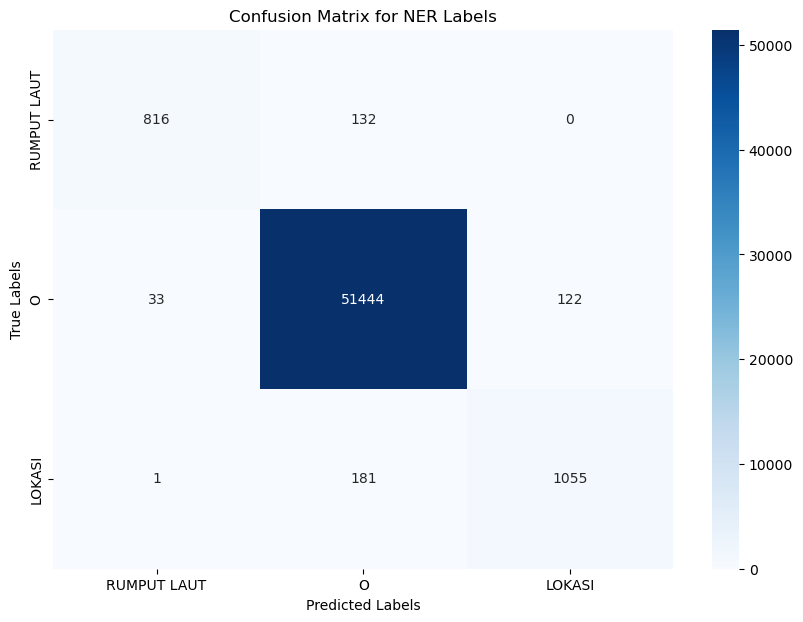

In [57]:
# Fungsi untuk menghapus prefix 'B-' atau 'I-' dari label
def remove_prefix(labels, idx2tag):
    return [
        idx2tag[idx].split("-")[-1] if "-" in idx2tag[idx] else idx2tag[idx]
        for idx in labels
    ]


# Mendapatkan label prediksi dan ground truth dalam bentuk ravel (flatten)
y_true = np.argmax(y_test, axis=2).ravel()
y_pred = np.argmax(p, axis=2).ravel()

# Transformasi label untuk menghilangkan prefix 'B-' atau 'I-'
y_true_transformed = remove_prefix(y_true, idx2tag)
y_pred_transformed = remove_prefix(y_pred, idx2tag)

# Buat confusion matrix
labels = list(set(y_true_transformed))  # Dapatkan label unik
cm = confusion_matrix(y_true_transformed, y_pred_transformed, labels=labels)

# Visualisasi confusion matrix menggunakan seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for NER Labels")
plt.show()

In [58]:
print(cm)

[[  816   132     0]
 [   33 51444   122]
 [    1   181  1055]]


## Seqeval

In [59]:
from seqeval.metrics import classification_report, accuracy_score


# Fungsi untuk menghapus prefix 'B-' atau 'I-' dari label
def remove_prefix(labels, idx2tag):
    return [
        idx2tag[idx].split("-")[-1] if "-" in idx2tag[idx] else idx2tag[idx]
        for idx in labels
    ]


# Mendapatkan label prediksi dan ground truth dalam bentuk ravel (flatten)
y_true = np.argmax(y_test, axis=2)
y_pred = np.argmax(p, axis=2)

# Mengubah format dari indeks ke label string
y_true_labels = [[idx2tag[idx] for idx in seq] for seq in y_true]
y_pred_labels = [[idx2tag[idx] for idx in seq] for seq in y_pred]

# Evaluasi menggunakan seqeval
print("Accuracy:", accuracy_score(y_true_labels, y_pred_labels))
print("Classification Report:")
print(classification_report(y_true_labels, y_pred_labels))

Accuracy: 0.9905919976201101
Classification Report:
              precision    recall  f1-score   support

      LOKASI       0.72      0.70      0.71       576
 RUMPUT LAUT       0.88      0.82      0.85       559

   micro avg       0.80      0.76      0.78      1135
   macro avg       0.80      0.76      0.78      1135
weighted avg       0.80      0.76      0.78      1135



# Thank You 🙏